## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random
import torch.nn as nn
import torch.optim as optim
import math
from torch.utils.data import TensorDataset, random_split, DataLoader
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm
from torchinfo import summary
from scipy.interpolate import interp1d, BSpline, splrep
from csaps import csaps
from skfda.representation.interpolation import SplineInterpolation
from scipy.interpolate import UnivariateSpline
from tslearn.metrics import SoftDTWLossPyTorch
from torch.utils.data import DataLoader, TensorDataset
from scipy.spatial.distance import cdist
import seaborn as sns
from depth.multivariate import *
from scipy import stats
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

normalize_data_01 = False
normalize_data_mean = False
if normalize_data_01 and normalize_data_mean:
    raise ValueError("Both 'normalize_data_01' and 'normalize_data_mean' cannot be True simultaneously.")
normalize_data = normalize_data_01 + normalize_data_mean

/Users/micheledisabato/Library/Python/3.9/lib/python/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Import and plot the dataset

In [2]:
df_raw_data = pd.read_csv('ECG5000/ecg.csv', header=None)
df_raw_data.columns = [f't{i+1}' for i in range(df_raw_data.shape[1] - 1)] + ['label'] # 4998x140 (+1 column for labels); 1: normal, 0: anomalous; 2079 normal
torch_data_normal = torch.tensor(df_raw_data[df_raw_data['label'] == True].values[:,:-1], dtype=torch.float32)
torch_data_anomalous = torch.tensor(df_raw_data[df_raw_data['label'] == False].values[:,:-1], dtype=torch.float32)

Hold out some training data for testing

In [3]:
hold_out_idx = torch.tensor(random.sample(range(torch_data_normal.shape[0]), 100))
all_indices = torch.arange(torch_data_normal.shape[0])
remaining_indices = all_indices[~torch.isin(all_indices, hold_out_idx)]
hold_out_normal = torch_data_normal[hold_out_idx,:]
torch_data_normal = torch_data_normal[remaining_indices,:]

print(f'Training data (normal): {torch_data_normal.shape[0]}')
print(f'Anomalous data: {torch_data_anomalous.shape[0]}')
print(f'Hold-out data (normal): {hold_out_normal.shape[0]}')
print(f'Total data: {hold_out_normal.shape[0]+torch_data_anomalous.shape[0]+torch_data_normal.shape[0]}')

Training data (normal): 2819
Anomalous data: 2079
Hold-out data (normal): 100
Total data: 4998


Normalize the data

In [4]:
if normalize_data_01:
    m_min, _ = torch.min(torch_data_normal, dim=0)
    m_max, _ = torch.max(torch_data_normal, dim=0)

    torch_data_normal = (torch_data_normal - m_min) / (m_max - m_min)
    torch_data_anomalous = (torch_data_anomalous - m_min) / (m_max - m_min)
    hold_out_normal = (hold_out_normal - m_min) / (m_max - m_min)

if normalize_data_mean:
    m_mean = torch_data_normal.mean(dim=0)
    torch_data_normal = torch_data_normal - m_mean
    torch_data_anomalous = torch_data_anomalous - m_mean
    hold_out_normal = hold_out_normal - m_mean

    torch_full = torch.concat((torch_data_normal, torch_data_anomalous))

if normalize_data:
    torch_full = torch.concat((torch_data_normal, torch_data_anomalous))
    df_data = pd.DataFrame(torch_full.detach().numpy())
    labels = torch.concat((
        torch.ones(torch_data_normal.shape[0]), 
        torch.zeros(torch_data_anomalous.shape[0])
    ))
    df_data['label'] = labels.numpy()


    fig, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
    [axs[0].plot(row, color='forestgreen', linewidth=0.5) for row in df_data[df_data['label'] == 1].iloc[:, :-1].values]
    [axs[1].plot(row, color='red', linewidth=0.5) for row in df_data[df_data['label'] == 0].iloc[:, :-1].values]
    if normalize_data_01:
        axs[0].set(title='[0,1]-normalized signals (Label = 1)', xlabel='Time Steps', ylabel='ECG')
        axs[1].set(title='[0,1]-normalized signals (Label = 0)', xlabel='Time Steps', ylabel='ECG')
        axs[0].set_ylim([-0.1,1.1])
    if normalize_data_mean:
        axs[0].set(title='mean-centered signals (Label = 1)', xlabel='Time Steps', ylabel='ECG')
        axs[1].set(title='mean-centered signals (Label = 0)', xlabel='Time Steps', ylabel='ECG')
    plt.show()

    # fig, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
    # [axs[0].plot(row, color='forestgreen', linewidth=0.5) for row in df_data[df_data['label'] == 1].iloc[:, :-1].values]
    # [axs[1].plot(row, color='red', linewidth=0.5) for row in df_data[df_data['label'] == 0].iloc[:, :-1].values]
    # axs[0].set(title='[0,1]-normalized signals (Label = 1)', xlabel='Time Steps', ylabel='ECG')
    # axs[1].set(title='[0,1]-normalized signals (Label = 0)', xlabel='Time Steps', ylabel='ECG')
    # axs[0].set_ylim([-0.1,1.1])
    # plt.show()

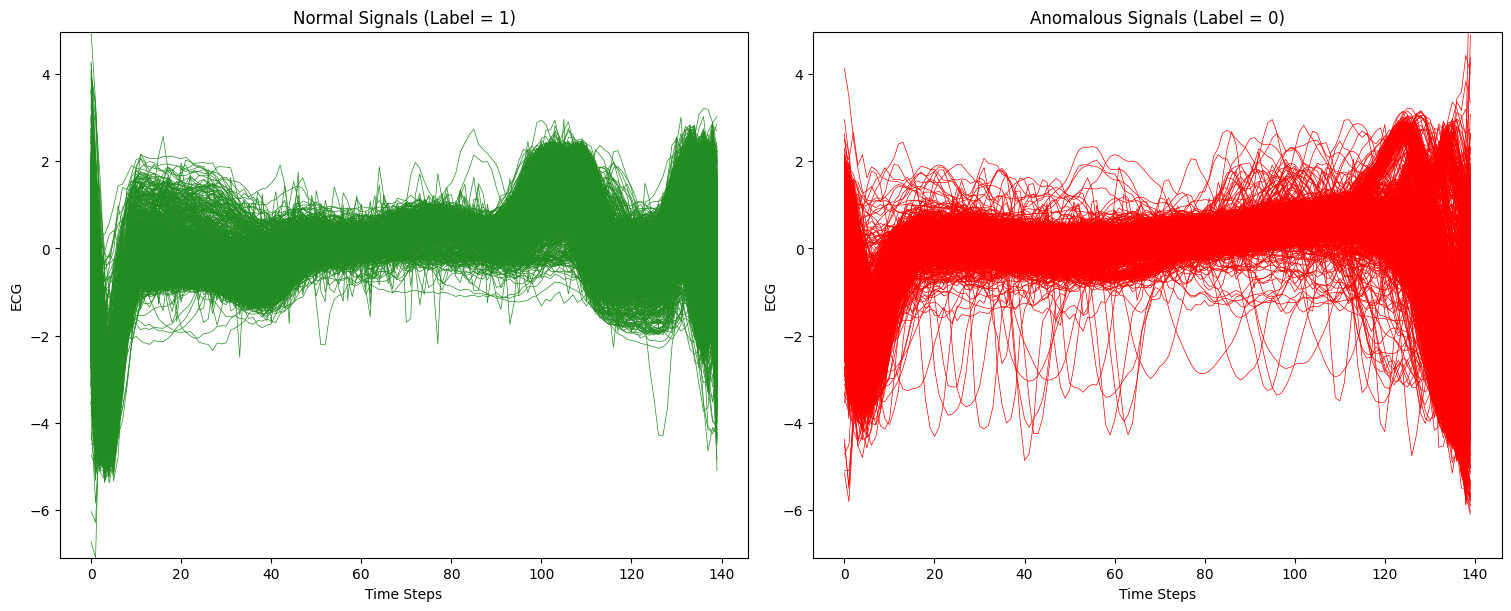

In [5]:
if not normalize_data:
    fig, axs = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
    [axs[0].plot(row, color='forestgreen', linewidth=0.5) for row in df_raw_data[df_raw_data['label'] == 1].iloc[:, :-1].values]
    [axs[1].plot(row, color='red', linewidth=0.5) for row in df_raw_data[df_raw_data['label'] == 0].iloc[:, :-1].values]
    axs[0].set(title='Normal Signals (Label = 1)', xlabel='Time Steps', ylabel='ECG')
    axs[1].set(title='Anomalous Signals (Label = 0)', xlabel='Time Steps', ylabel='ECG')
    axs[0].set_ylim([df_raw_data[df_raw_data['label'] == True].min().min(), df_raw_data[df_raw_data['label'] == True].max().max()])
    axs[1].set_ylim([df_raw_data[df_raw_data['label'] == True].min().min(), df_raw_data[df_raw_data['label'] == True].max().max()])
    plt.show()

if normalize_data_01:
    fig, axs = plt.subplots(2, 2, figsize=(15, 12), constrained_layout=True)
    [axs[0, 0].plot(row, color='forestgreen', linewidth=0.5) for row in df_data[df_data['label'] == 1].iloc[:, :-1].values]
    [axs[0, 1].plot(row, color='red', linewidth=0.5) for row in df_data[df_data['label'] == 0].iloc[:, :-1].values]
    axs[0, 0].set(title='[0,1]-normalized signals (Label = 1)', xlabel='Time Steps', ylabel='ECG')
    axs[0, 1].set(title='[0,1]-normalized signals (Label = 0)', xlabel='Time Steps', ylabel='ECG')
    axs[0, 0].set_ylim([-0.1, 1.1])
    [axs[1, 0].plot(row, color='forestgreen', linewidth=0.5) for row in df_raw_data[df_raw_data['label'] == 1].iloc[:, :-1].values]
    [axs[1, 1].plot(row, color='red', linewidth=0.5) for row in df_raw_data[df_raw_data['label'] == 0].iloc[:, :-1].values]
    axs[1, 0].set(title='Normal Signals (Label = 1)', xlabel='Time Steps', ylabel='ECG')
    axs[1, 1].set(title='Anomalous Signals (Label = 0)', xlabel='Time Steps', ylabel='ECG')
    axs[1, 0].set_ylim([df_raw_data[df_raw_data['label'] == True].min().min(), df_raw_data[df_raw_data['label'] == True].max().max()])
    axs[1, 1].set_ylim([df_raw_data[df_raw_data['label'] == True].min().min(), df_raw_data[df_raw_data['label'] == True].max().max()])
    plt.show()

if normalize_data_mean:
    fig, axs = plt.subplots(2, 2, figsize=(15, 12), constrained_layout=True)
    [axs[0, 0].plot(row, color='forestgreen', linewidth=0.5) for row in df_data[df_data['label'] == 1].iloc[:, :-1].values]
    [axs[0, 1].plot(row, color='red', linewidth=0.5) for row in df_data[df_data['label'] == 0].iloc[:, :-1].values]
    axs[0, 0].set(title='mean-centered signals (Label = 1)', xlabel='Time Steps', ylabel='ECG')
    axs[0, 1].set(title='mean-centered signals (Label = 1)', xlabel='Time Steps', ylabel='ECG')
    [axs[1, 0].plot(row, color='forestgreen', linewidth=0.5) for row in df_raw_data[df_raw_data['label'] == 1].iloc[:, :-1].values]
    [axs[1, 1].plot(row, color='red', linewidth=0.5) for row in df_raw_data[df_raw_data['label'] == 0].iloc[:, :-1].values]
    axs[1, 0].set(title='Normal Signals (Label = 1)', xlabel='Time Steps', ylabel='ECG')
    axs[1, 1].set(title='Anomalous Signals (Label = 0)', xlabel='Time Steps', ylabel='ECG')
    axs[1, 0].set_ylim([df_raw_data[df_raw_data['label'] == True].min().min(), df_raw_data[df_raw_data['label'] == True].max().max()])
    axs[1, 1].set_ylim([df_raw_data[df_raw_data['label'] == True].min().min(), df_raw_data[df_raw_data['label'] == True].max().max()])
    plt.show()

## Define and apply the mask

In [6]:
# def construct_mask(from_, to_, n_, bounds_ = None):
#     # bounds_ is a list of lists that contain the endpoints of the intervals to be selected (if bounds_ = [[0, 1]], then no mask is applied)
#     if bounds_ is None: 
#         bounds_ = [[0, 1]]
#     x_dense = np.linspace(from_,to_,n_)
#     x_out = np.linspace(from_,to_,n_)
#     y_dense = np.zeros(n_)
#     for bound_ in bounds_:
#         y_dense[(x_dense >= bound_[0]) & (x_dense <= bound_[1])] = 1
#     return(interp1d(x_dense, y_dense)(x_out))

# mask = construct_mask(0, 1, raw_data.shape[1], [[0.3, 0.7]]) 
# mask = construct_mask(0, 139, raw_data.shape[1], [[0, 1]]) 
# mean_subtracted_data = mean_subtracted_data.T.apply(lambda v: v*mask).T
# data = raw_data.iloc[:, mask == 1]

## Define the model

In [7]:
class TimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(TimeSeriesAutoencoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim)
        )

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded

## Train the model

See structure of the model and number of parameters, initialize the model, set learning rate, number of epochs and optimizer

In [ ]:
num_epochs = 300
learning_rate = 0.01

model = TimeSeriesAutoencoder(torch_data_normal.shape[1], 10)
summary(model, input_data=torch.randn(1, torch_data_normal.shape[1]), verbose=0, col_names=["kernel_size", "output_size", "num_params"])

# def initialize_weights(model):
#     for layer in model.modules():
#         if isinstance(layer, nn.Conv1d) or isinstance(layer, nn.Linear):
#             nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
#             if layer.bias is not None:
#                 nn.init.constant_(layer.bias, 0)
# initialize_weights(model)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

To train in batches

In [9]:
batch_size = 64 
TD_torch_data = TensorDataset(torch_data_normal)
data_loader = DataLoader(TD_torch_data, batch_size=batch_size, shuffle=True)
for epoch in range(num_epochs):
    model.train()  # model to training mode
    epoch_loss = 0.0  # To track loss across all batches
    for batch in data_loader:
        batch_x = batch[0]  # Extract the input from the DataLoader batch
        output = model(batch_x)
        # print(batch_x.shape, output.shape)
        loss = loss_function(output, batch_x)  # MSE loss
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights
        epoch_loss += loss.item()  # Accumulate loss
    if (epoch + 1) % 30 == 0 or epoch == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(data_loader):.4f}")


Epoch [1/500], Loss: 0.3009
Epoch [30/500], Loss: 0.0309
Epoch [60/500], Loss: 0.0227
Epoch [90/500], Loss: 0.0224
Epoch [120/500], Loss: 0.0177
Epoch [150/500], Loss: 0.0189
Epoch [180/500], Loss: 0.0163
Epoch [210/500], Loss: 0.0156
Epoch [240/500], Loss: 0.0149
Epoch [270/500], Loss: 0.0165
Epoch [300/500], Loss: 0.0154
Epoch [330/500], Loss: 0.0150
Epoch [360/500], Loss: 0.0151
Epoch [390/500], Loss: 0.0162
Epoch [420/500], Loss: 0.0150
Epoch [450/500], Loss: 0.0153
Epoch [480/500], Loss: 0.0184


To train using the whole dataset

In [10]:
# for epoch in range(num_epochs):
#     model.train()  # model to training mode
#     output = model(torch_data)
#     loss = loss_function(output, torch_data)  # MSE loss
#     optimizer.zero_grad()  # Clear gradients
#     loss.backward()        # Backpropagation
#     optimizer.step()       # Update weights
#     if (epoch + 1) % 30 == 0 or epoch == 0:
#         print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

## Have a look at model's performance

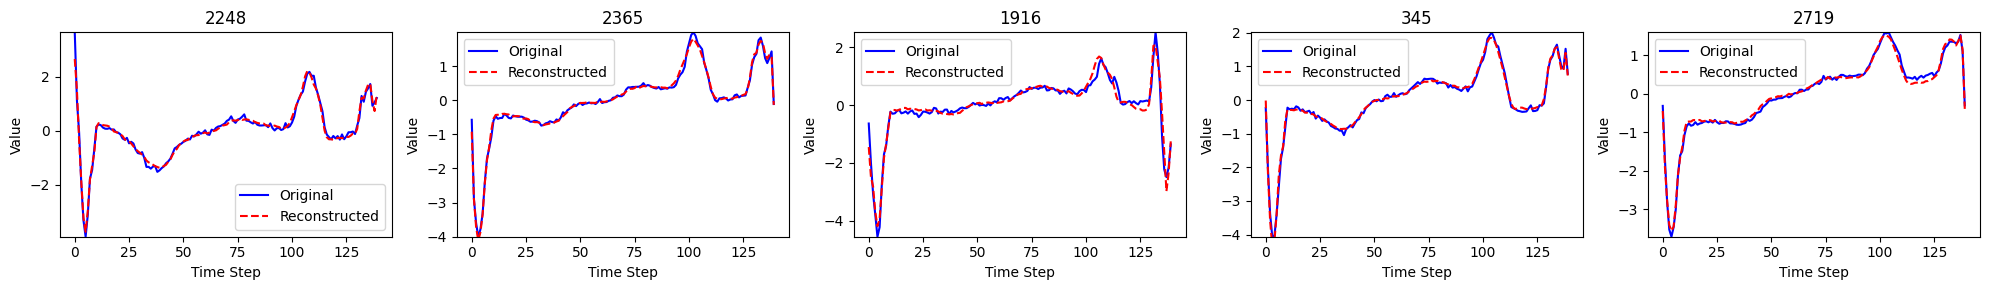

In [11]:
model.eval()
with torch.no_grad():
    reconstructed_normal = model(torch_data_normal)
index_ = random.sample(range(torch_data_normal.shape[0]), 5)
original_sequence_normal = torch_data_normal[index_, :].cpu().numpy()
reconstructed_sequence_normal = reconstructed_normal[index_, :].cpu().numpy()

vertical_plot = False
if vertical_plot:
    plt.figure(figsize=(6, len(index_) * 2)) # stacked on top of each other
if not vertical_plot:
    plt.figure(figsize=(len(index_) * 4, 3)) # stacked side by side
for i, idx in enumerate(index_):
    if vertical_plot:
        plt.subplot(len(index_), 1, i + 1) # stacked on top of each other
    if not vertical_plot:
        plt.subplot(1, len(index_), i + 1) # stacked side by side
    plt.plot(original_sequence_normal[i, :], label="Original", color="blue")
    plt.plot(reconstructed_sequence_normal[i, :], label="Reconstructed", color="red", linestyle="dashed")
    plt.title(f"{idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.ylim([min(original_sequence_normal[i, :]), max(original_sequence_normal[i, :])])
    plt.legend()

plt.tight_layout()
plt.show()

How are the anomalies reconstructed?

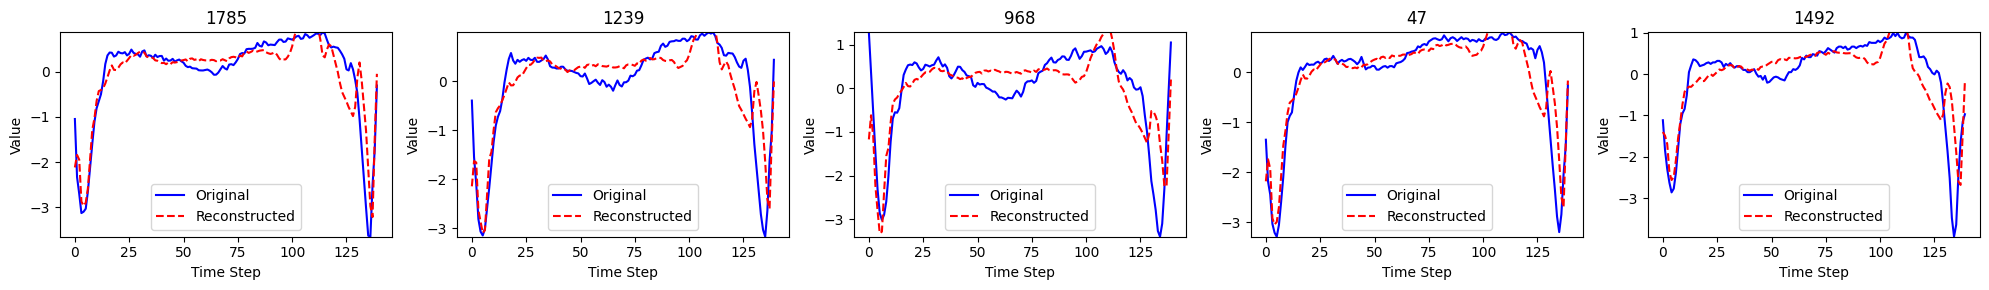

In [12]:
model.eval()
with torch.no_grad():
    reconstructed_anomalous = model(torch_data_anomalous)
index_ = random.sample(range(torch_data_anomalous.shape[0]), 5)
original_sequence_anomalous = torch_data_anomalous[index_, :].cpu().numpy()
reconstructed_sequence_anomalous = reconstructed_anomalous[index_, :].cpu().numpy()

vertical_plot = False
if vertical_plot:
    plt.figure(figsize=(6, len(index_) * 2)) # stacked on top of each other
if not vertical_plot:
    plt.figure(figsize=(len(index_) * 4, 3)) # stacked side by side
for i, idx in enumerate(index_):
    if vertical_plot:
        plt.subplot(len(index_), 1, i + 1) # stacked on top of each other
    if not vertical_plot:
        plt.subplot(1, len(index_), i + 1) # stacked side by side
    plt.plot(original_sequence_anomalous[i, :], label="Original", color="blue")
    plt.plot(reconstructed_sequence_anomalous[i, :], label="Reconstructed", color="red", linestyle="dashed")
    plt.title(f"{idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.ylim([min(original_sequence_anomalous[i, :]), max(original_sequence_anomalous[i, :])])
    plt.legend()

plt.tight_layout()
plt.show()

How are the hold out reconstructed?

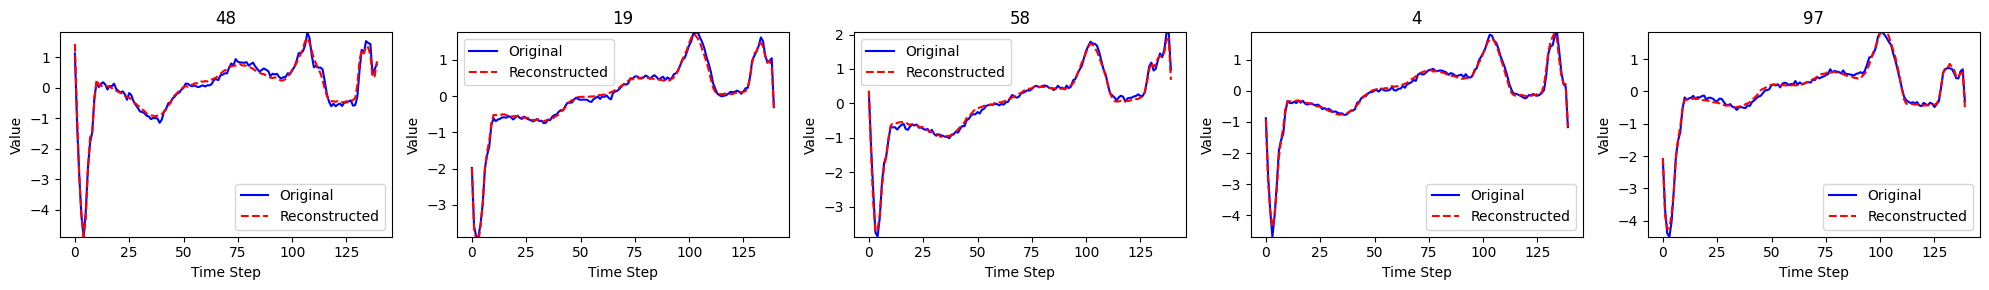

In [13]:
model.eval()
with torch.no_grad():
    reconstructed_hold_out = model(hold_out_normal)
index_ = random.sample(range(hold_out_normal.shape[0]), 5)
original_sequence_hold_out = hold_out_normal[index_, :].cpu().numpy()
reconstructed_sequence_hold_out = reconstructed_hold_out[index_, :].cpu().numpy()

vertical_plot = False
if vertical_plot:
    plt.figure(figsize=(6, len(index_) * 2)) # stacked on top of each other
if not vertical_plot:
    plt.figure(figsize=(len(index_) * 4, 3)) # stacked side by side
for i, idx in enumerate(index_):
    if vertical_plot:
        plt.subplot(len(index_), 1, i + 1) # stacked on top of each other
    if not vertical_plot:
        plt.subplot(1, len(index_), i + 1) # stacked side by side
    plt.plot(original_sequence_hold_out[i, :], label="Original", color="blue")
    plt.plot(reconstructed_sequence_hold_out[i, :], label="Reconstructed", color="red", linestyle="dashed")
    plt.title(f"{idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.ylim([min(original_sequence_hold_out[i, :]), max(original_sequence_hold_out[i, :])])
    plt.legend()

plt.tight_layout()
plt.show()

## Look at encoded features

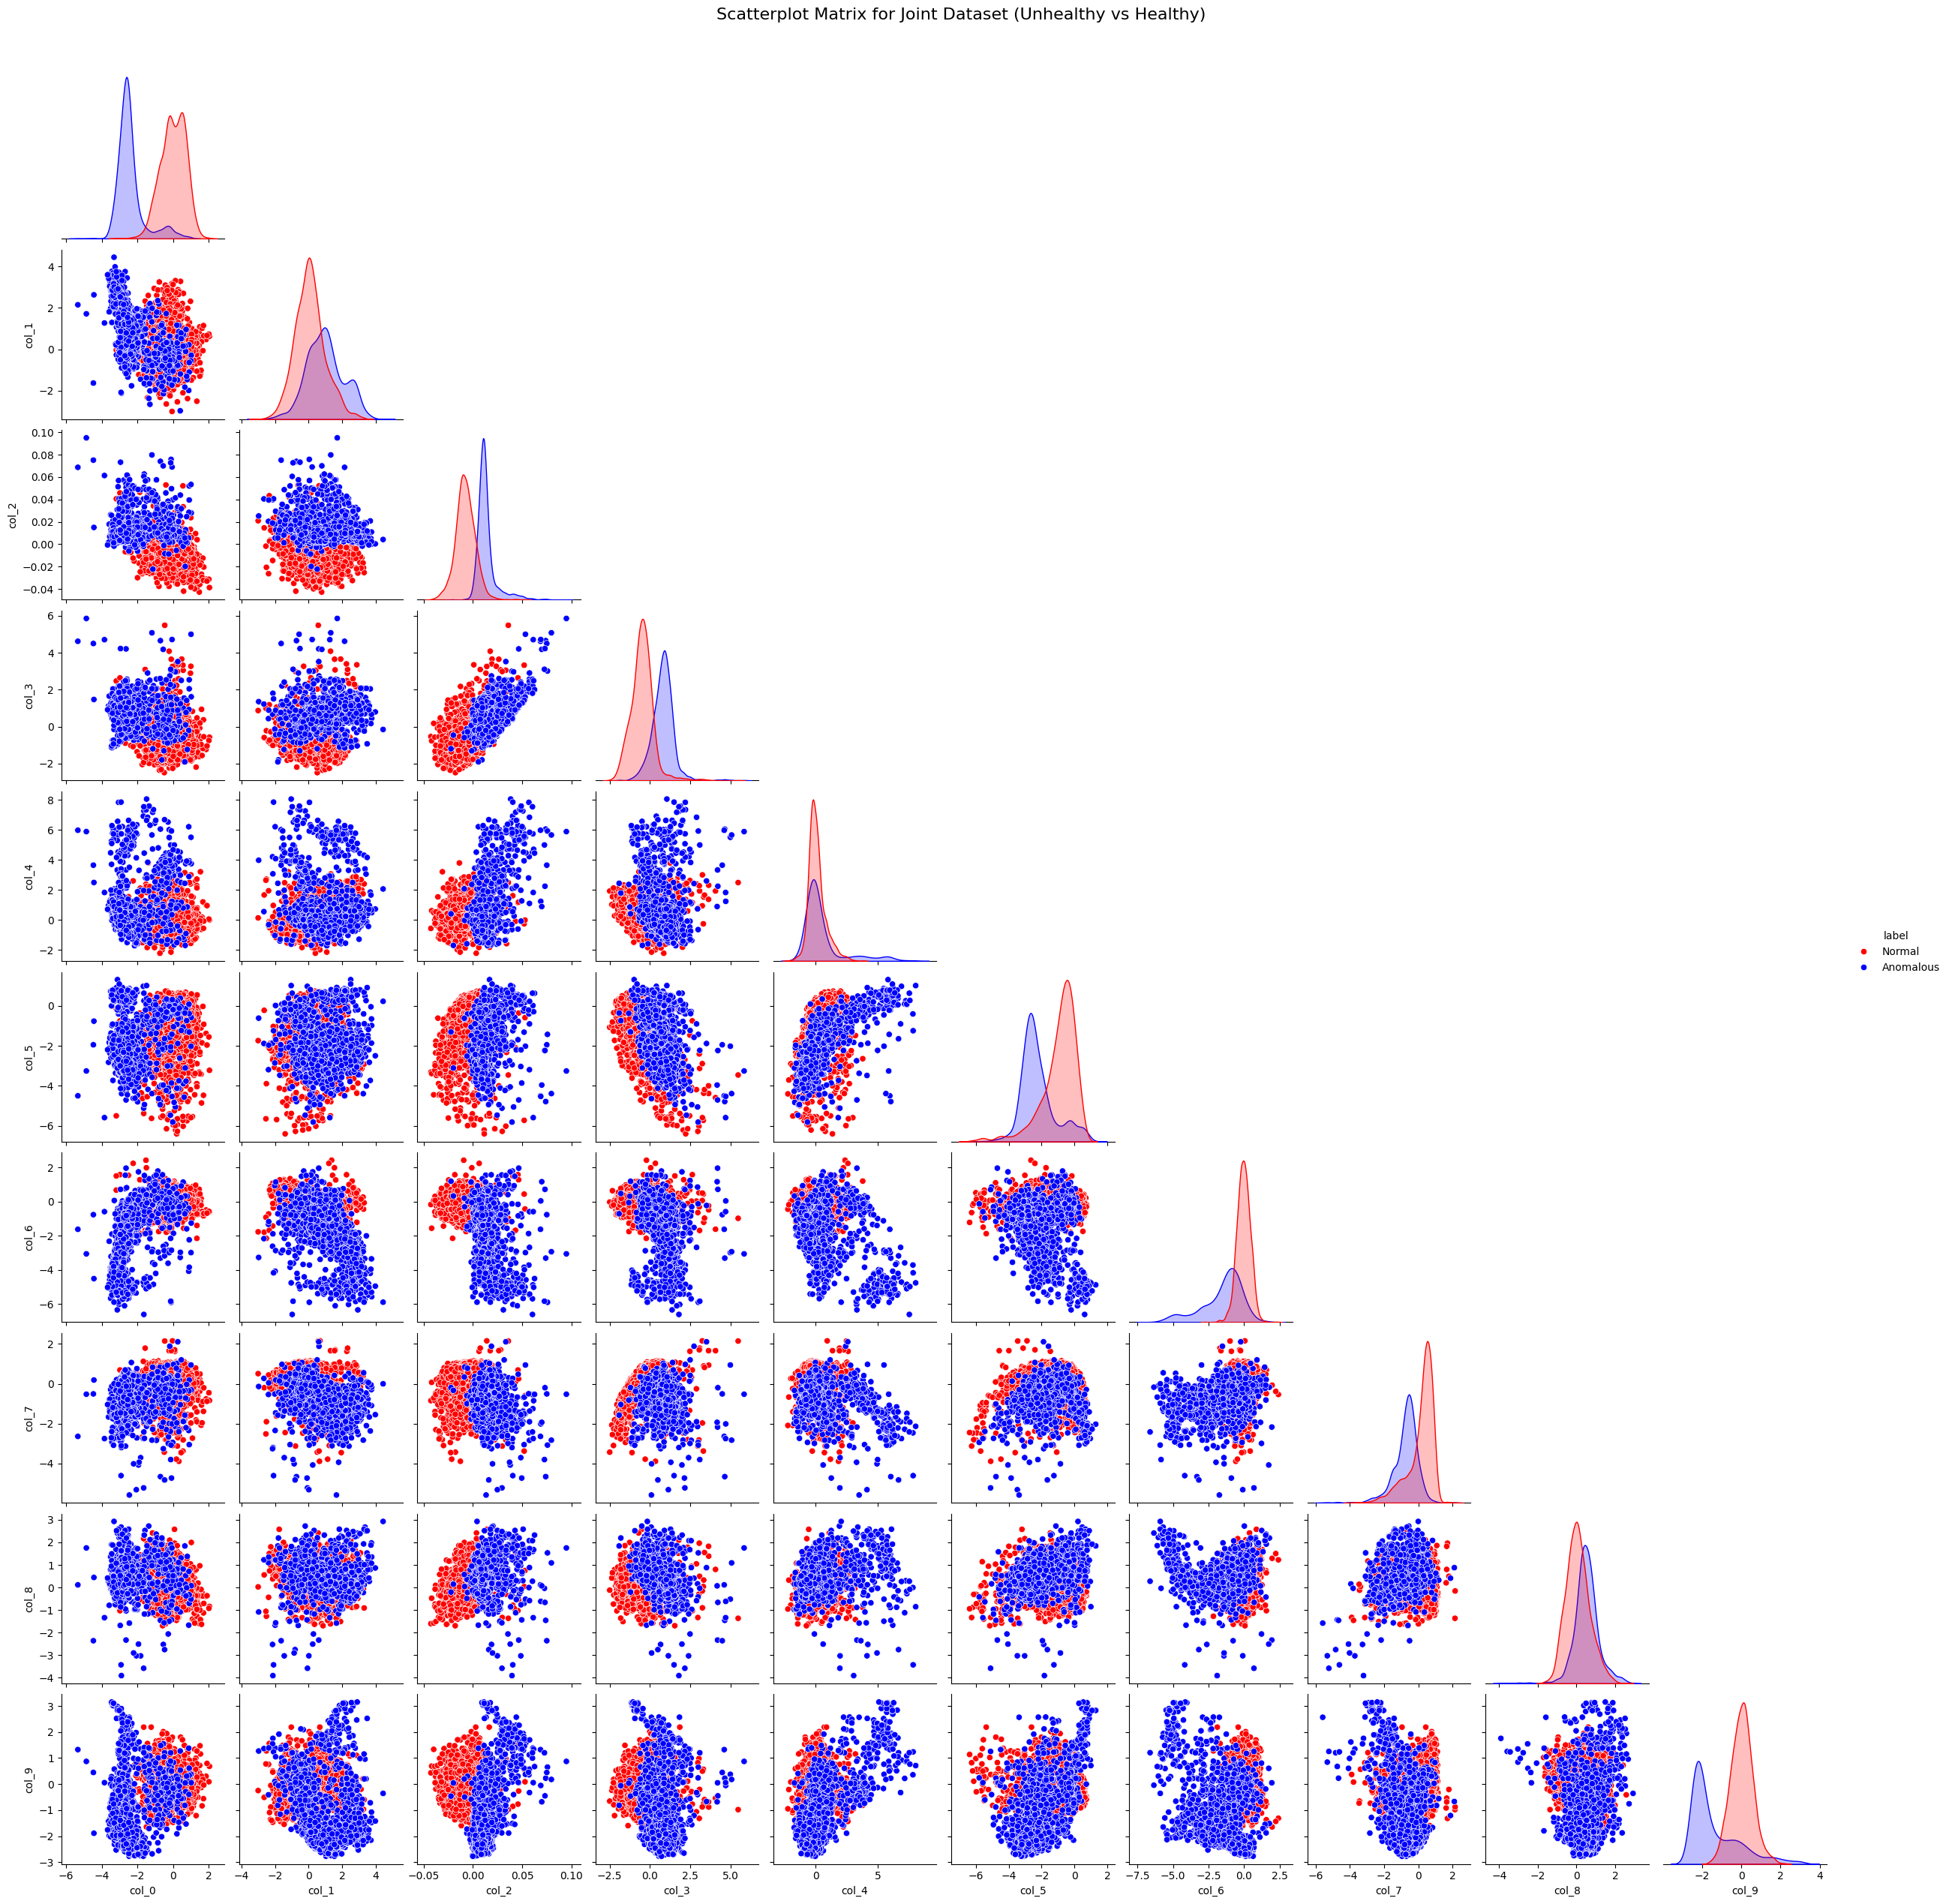

In [14]:
encoded_normal = model.encode(torch_data_normal).detach().numpy()
encoded_anomalous = model.encode(torch_data_anomalous).detach().numpy()
df_encoded_normal = pd.DataFrame(encoded_normal, columns=[f"col_{i}" for i in range(encoded_normal.shape[1])])
df_encoded_anomalous = pd.DataFrame(encoded_anomalous, columns=[f"col_{i}" for i in range(encoded_normal.shape[1])])

def scatterplot_matrix_with_means(data, title):
    means = data.mean()  
    g = sns.pairplot(data, diag_kind="kde", corner=True)
    for i, j in zip(*np.tril_indices_from(g.axes, -1)):  
        ax = g.axes[i, j]
        mean_x, mean_y = means.iloc[j], means.iloc[i]
        ax.scatter(mean_x, mean_y, color='red', s=100, label='Sample Mean')
        ax.legend()
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.show()

# scatterplot_matrix_with_means(encoded_unhealthy_df, title="Scatterplot Matrix with Means (Unhealthy)")
# scatterplot_matrix_with_means(encoded_healthy_df, title="Scatterplot Matrix with Means (Healthy)")

df_encoded_anomalous['label'] = 'Anomalous'
df_encoded_normal['label'] = 'Normal'
df_joint_dataset = pd.concat([df_encoded_normal, df_encoded_anomalous], ignore_index=True)

def scatterplot_matrix_with_labels(data, title):
    g = sns.pairplot(data, diag_kind="kde", hue='label', corner=True, palette={"Normal": "red", "Anomalous": "blue"})
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.show()

scatterplot_matrix_with_labels(df_joint_dataset, title="Scatterplot Matrix for Joint Dataset (Unhealthy vs Healthy)")

## Compare the normal and anomalous signals

Using the loss function on the reconstructed signal

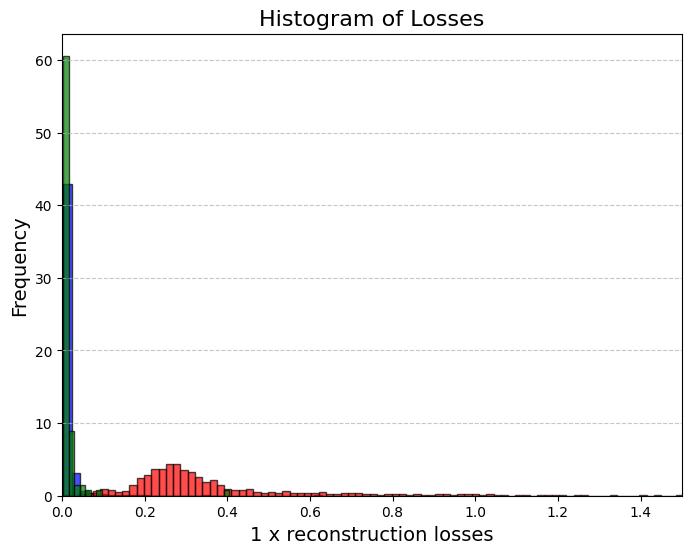

In [15]:
mse_loss = nn.MSELoss() 
normal_loss = []
anomalous_loss = []
hold_out_loss = []
rescaling_factor = 20 # for plotting
if not normalize_data:
    rescaling_factor = 1

for i in range(reconstructed_normal.shape[0]):
    normal_loss.append(rescaling_factor * mse_loss(reconstructed_normal[i,:], torch_data_normal[i,:]).numpy())

for i in range(reconstructed_anomalous.shape[0]):
    anomalous_loss.append(rescaling_factor * mse_loss(reconstructed_anomalous[i,:], torch_data_anomalous[i,:]).numpy())

for i in range(reconstructed_hold_out.shape[0]):
    hold_out_loss.append(rescaling_factor * mse_loss(reconstructed_hold_out[i,:], hold_out_normal[i,:]).numpy())

plt.figure(figsize=(8, 6))
plt.hist(normal_loss, bins=30, color='blue', alpha=0.7, edgecolor='black', density = True)
plt.title("Histogram of Losses", fontsize=16)
plt.xlabel(f"{rescaling_factor} x reconstruction losses", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.axvline(depths_unhealthy[1], color='red', linestyle='--', linewidth=2, label='First Component of Depths Unhealthy')
plt.hist(anomalous_loss, bins=100, color='red', alpha=0.7, edgecolor='black', density = True)
plt.hist(hold_out_loss, bins=30, color='green', alpha=0.7, edgecolor='black', density = True)
plt.xlim([0, 1.5])
plt.show()

In [16]:
print(stats.kstest(normal_loss, anomalous_loss))
print(stats.kstest(normal_loss, hold_out_loss))

KstestResult(statistic=0.9725650566374228, pvalue=0.0, statistic_location=0.06810858100652695, statistic_sign=1)
KstestResult(statistic=0.07054274565448741, pvalue=0.6946642491765391, statistic_location=0.005793569143861532, statistic_sign=1)
